In [ ]:
!wget https://mimuw.edu.pl/~bilinski/VRNN2022/labs/datasets/cifar10.npz

--2022-03-08 10:58:53--  https://mimuw.edu.pl/~bilinski/VRNN2022/labs/datasets/cifar10.npz
Resolving mimuw.edu.pl (mimuw.edu.pl)... 193.0.96.14
Connecting to mimuw.edu.pl (mimuw.edu.pl)|193.0.96.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 742080894 (708M)
Saving to: ‘cifar10.npz’

cifar10.npz         100%[===================>] 707.70M  6.65MB/s    in 1m 54s  

2022-03-08 11:00:48 (6.21 MB/s) - ‘cifar10.npz’ saved [742080894/742080894]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 
                    'dog', 'frog', 'horse', 'ship', 'truck'])
images =  np.load("cifar10.npz")
images.files

['Xte', 'Yte', 'Ytr', 'Xtr']

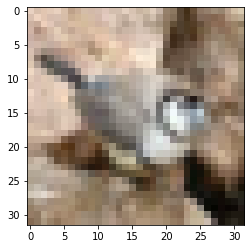

In [ ]:
def display_sample(sample):
    single_image = sample
    single_image = single_image.reshape(3, 32, 32)
    single_image = single_image.transpose((1,2,0))
    single_image *= 32
    plt.imshow(single_image)
    plt.show()

def display_samples(samples):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    for i, sample in enumerate(samples):
      sample = sample.reshape(3, 32, 32)
      sample = sample.transpose((1,2,0))
      sample *= 32
      ax[i].imshow(sample)
    plt.show()

display_sample(images["Xtr"][90])

In [ ]:
def l1(sample, test):
    return np.sqrt(np.sum(np.absolute(sample-test)))

def l2(sample, test):
    return np.sqrt(np.sum(np.power(sample-test, 2)))

def nn(train_x, test_x, l1=False):
    reg_func = l2
    if l1:
      reg_func = l1

    dists = []
    for i, sample in enumerate(train_x):
      dist = reg_func(sample, test_x)
      dists.append((i, dist))
    return min(dists, key=lambda x: x[1])

def knn(train_x, train_y, test_x, k=3, use_l1=False):
    reg_func = l2
    if use_l1:
      reg_func = l1
    dists = []
    for i, sample in enumerate(train_x):
      dist = reg_func(sample, test_x)
      dists.append((i, dist))
    ids =  [i[0] for i in sorted(dists, key=lambda x: x[1])[:k]]
    classes = np.array([train_y[i].astype("bool") for i in ids])
    uniq = np.unique(classes, return_index=True, return_counts=True, axis=0)
    argmax = np.argmax(uniq[2])
    return uniq[0][argmax], ids[uniq[1][argmax]]

def get_class(id_vector, classes):
    return classes[id_vector][0]

dog
cat


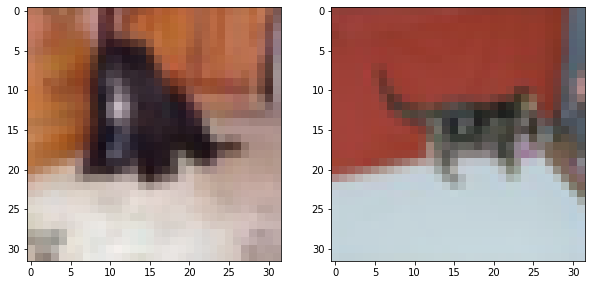

In [ ]:
test_id = np.random.randint(len(images["Xte"]))
test_x = images["Xte"][test_id]
test_y = images["Yte"][test_id].astype("bool")

predicted_y_id = nn(images["Xtr"], images["Xte"][test_id])[0]

print(get_class(test_y, classes))
print(get_class(images["Ytr"][predicted_y_id].astype("bool"), classes))

display_samples([test_x, images["Xtr"][predicted_y_id]])

truck
truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


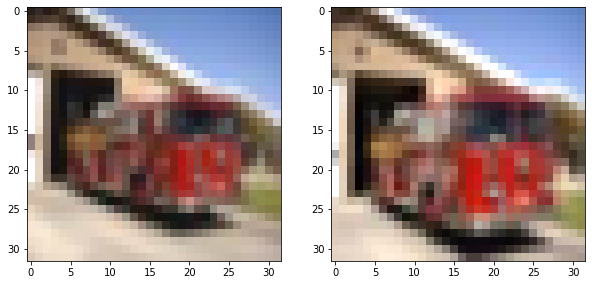

In [ ]:
test_id = np.random.randint(len(images["Xte"]))
test_x = images["Xte"][test_id]
test_y = images["Yte"][test_id].astype("bool")

predicted_y, predicted_y_id = knn(images["Xtr"], images["Ytr"], test_x, k=5, use_l1=True)

print(get_class(test_y, classes))
print(get_class(predicted_y, classes))

display_samples([test_x, images["Xtr"][predicted_y_id]])

In [ ]:
full_xtrain = images["Xtr"][0:len(images["Xtr"]):10]
full_ytrain = images["Ytr"][0:len(images["Xtr"]):10]
ks = {}
fold = 4
for k in [1, 3, 5, 7]:
    p = []
    for i in range(0, len(full_xtrain), fold):
      xtest, xtrain = full_xtrain[i:i+fold], np.concatenate((full_xtrain[:i], full_xtrain[i+fold:]))
      ytest, ytrain = full_ytrain[i:i+fold], np.concatenate((full_ytrain[:i], full_ytrain[i+fold:]))
    
      total = 0
      good = 0
      for i in range(fold):
        predicted_y, predicted_y_id = knn(xtrain, ytrain, xtest[i], k=k, use_l1=True)
        if np.array_equal(ytest[i], predicted_y):
          good += 1
        total += 1
      p.append(good/total)
    ks[k] = np.mean(p)

ks

{1: 0.2928, 3: 0.3108, 5: 0.314, 7: 0.3154}

In [ ]:
xtrain = images["Xtr"][0:len(images["Xtr"]):100]
ytrain = images["Ytr"][0:len(images["Xtr"]):100]
xtest = images["Xte"][0:len(images["Xtr"]):100]
ytest = images["Yte"][0:len(images["Xtr"]):100]

ks = {}
fold = 4
for k in [1, 3, 5, 7]:
    p = []
    for i in range(0, len(full_xtrain), fold):
      xval, xtrain = xtrain[i:i+fold], np.concatenate((xtrain[:i], xtrain[i+fold:]))
      yval, ytrain = ytrain[i:i+fold], np.concatenate((ytrain[:i], ytrain[i+fold:]))
    
      total = 0
      good = 0
      for i, sample in enumerate(xtest):
        predicted_y, predicted_y_id = knn(xtrain, ytrain, sample, k=k, use_l1=True)
        if np.array_equal(ytest[i], predicted_y):
          good += 1
        total += 1
      p.append(good/total)
    ks[k] = np.mean(p)

ks

{1: 0.348872, 3: 0.24075200000000005, 5: 0.160896, 7: 0.17012}